In [1]:

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pkg.data import load_maggot_graph, select_nice_nodes
from pkg.io import FIG_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import SmartSVG, set_theme
from pkg.stats import erdos_renyi_test, stochastic_block_test
from svgutils.compose import Figure, Panel, Text
from tqdm import tqdm


DISPLAY_FIGS = True

FILENAME = "thresholding_tests"

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()

In [2]:

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
left_mg, right_mg = mg.bisect(lcc=True)
left_nodes = left_mg.nodes
right_nodes = right_mg.nodes

left_adj = left_mg.sum.adj
right_adj = right_mg.sum.adj

GROUP_KEY = "simple_group"

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [3]:

d_key = "Density"
gc_key = "Group connection"
dagc_key = "Density-adjusted\ngroup connection"


def binarize(A, threshold=None):
    # threshold is the smallest that is kept

    B = A.copy()

    if threshold is not None:
        B[B < threshold] = 0

    return B


rows = []
thresholds = np.arange(1, 10)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj, threshold=threshold)
    right_adj_thresh = binarize(right_adj, threshold=threshold)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": d_key,
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = dagc_key
        else:
            method = gc_key
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)

integer_results = pd.DataFrame(rows)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]


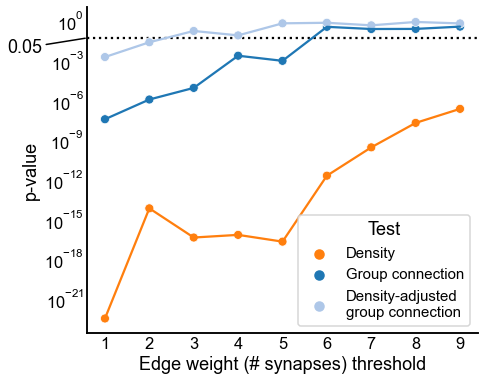

In [4]:
def add_alpha_line(ax):
    ax.axhline(0.05, color="black", linestyle=":", zorder=-1)
    ax.annotate(
        r"0.05",
        (ax.get_xlim()[0], 0.05),
        xytext=(-45, -15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-", color="black"),
        clip_on=False,
        ha="right",
    )


colors = sns.color_palette("tab20")
palette = dict(zip([gc_key, dagc_key, d_key], colors))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))


sns.scatterplot(
    data=integer_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
)
sns.lineplot(
    data=integer_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(yscale="log", ylabel="p-value", xlabel="Edge weight (# synapses) threshold")
sns.move_legend(ax, "lower right", title="Test", frameon=True, fontsize="small")
ax.set(xticks=thresholds)
add_alpha_line(ax)

gluefig("integer_threshold_pvalues", fig)

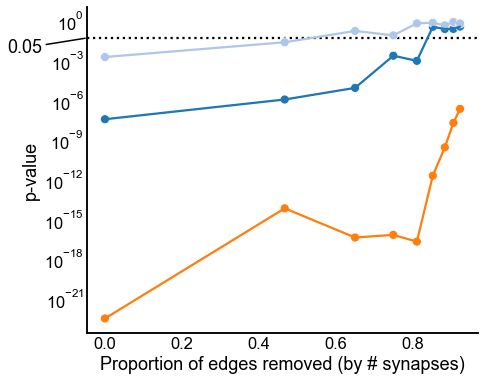

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))


sns.scatterplot(
    data=integer_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=integer_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(
    yscale="log", ylabel="p-value", xlabel="Proportion of edges removed (by # synapses)"
)
add_alpha_line(ax)
gluefig("integer_threshold_pvalues_p_removed", fig)

In [6]:
left_input = (left_nodes["axon_input"] + left_nodes["dendrite_input"]).values
left_input[left_input == 0] = 1
left_adj_input_norm = left_adj / left_input[None, :]

right_input = (right_nodes["axon_input"] + right_nodes["dendrite_input"]).values
right_input[right_input == 0] = 1
right_adj_input_norm = right_adj / right_input[None, :]

In [7]:


rows = []
thresholds = np.linspace(0, 0.03, 21)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj_input_norm, threshold=threshold)
    right_adj_thresh = binarize(right_adj_input_norm, threshold=threshold)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": d_key,
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = dagc_key
        else:
            method = gc_key
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)
input_results = pd.DataFrame(rows)
input_results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:15<00:00,  3.57s/it]


,threshold,stat,pvalue,method,p_edges_removed,adjusted
0,0.0000,3.082387e-23,3.082387e-23,Density,0.000000,NaN
1,0.0000,1.258385e-10,3.561229e-08,Group connection,0.000000,False
2,0.0000,6.344169e-06,1.793795e-03,Density-adjusted\ngroup connection,0.000000,True
3,0.0015,5.954349e-24,5.954349e-24,Density,0.005350,NaN
4,0.0015,1.258385e-10,3.561229e-08,Group connection,0.005350,False
...,...,...,...,...,...,...
58,0.0285,1.292440e-02,9.248839e-01,Group connection,0.818113,False
59,0.0285,7.358936e-03,7.700385e-01,Density-adjusted\ngroup connection,0.818113,True
60,0.0300,6.647336e-01,6.647336e-01,Density,0.830161,NaN
61,0.0300,3.900540e-02,9.996055e-01,Group connection,0.830161,False


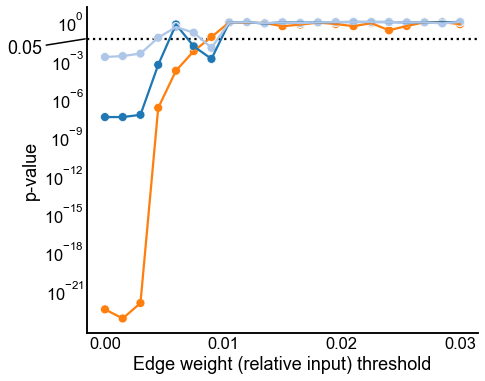

In [8]:


fig, ax = plt.subplots(1, 1, figsize=(7, 6))


sns.scatterplot(
    data=input_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=input_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(yscale="log", ylabel="p-value", xlabel="Edge weight (relative input) threshold")
ax.set(xticks=thresholds, yticks=np.geomspace(1, 1e-21, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
add_alpha_line(ax)

gluefig("input_threshold_pvalues", fig)

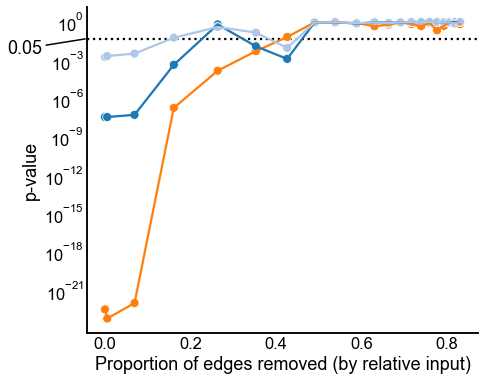

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.scatterplot(
    data=input_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=input_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(
    yscale="log",
    ylabel="p-value",
    xlabel="Proportion of edges removed (by relative input)",
    yticks=np.geomspace(1, 1e-21, 8),
)
add_alpha_line(ax)
gluefig("input_threshold_pvalues_p_removed", fig)

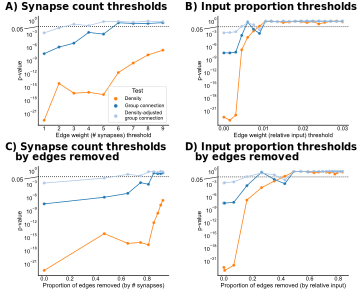

In [10]:


fontsize = 10

int_thresh = SmartSVG(FIG_PATH / "integer_threshold_pvalues.svg")
int_thresh.set_width(200)
int_thresh.move(10, 15)
int_thresh_panel = Panel(
    int_thresh, Text("A) Synapse count thresholds", 5, 10, size=fontsize, weight="bold")
)

input_thresh = SmartSVG(FIG_PATH / "input_threshold_pvalues.svg")
input_thresh.set_width(200)
input_thresh.move(10, 15)
input_thresh_panel = Panel(
    input_thresh,
    Text("B) Input proportion thresholds", 5, 10, size=fontsize, weight="bold"),
)
input_thresh_panel.move(int_thresh.width * 0.9, 0)

int_p_removed = SmartSVG(FIG_PATH / "integer_threshold_pvalues_p_removed.svg")
int_p_removed.set_width(200)
int_p_removed.move(10, 25)
int_p_removed_panel = Panel(
    int_p_removed,
    Text("C) Synapse count thresholds", 5, 10, size=fontsize, weight="bold"),
    Text("by edges removed", 15, 20, size=fontsize, weight="bold"),
)
int_p_removed_panel.move(0, int_thresh.height * 0.9)

input_p_removed = SmartSVG(FIG_PATH / "input_threshold_pvalues_p_removed.svg")
input_p_removed.set_width(200)
input_p_removed.move(10, 25)
input_p_removed_panel = Panel(
    input_p_removed,
    Text("D) Input proportion thresholds", 5, 10, size=fontsize, weight="bold"),
    Text("by edges removed", 15, 20, size=fontsize, weight="bold"),
)
input_p_removed_panel.move(int_thresh.width * 0.9, int_thresh.height * 0.9)

fig = Figure(
    int_thresh.width * 2 * 0.9,
    int_thresh.height * 2 * 0.95,
    int_thresh_panel,
    input_thresh_panel,
    int_p_removed_panel,
    input_p_removed_panel,
)
fig.save(FIG_PATH / "thresholding_composite.svg")
fig

In [11]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:02:20.124256
Completed at 2022-03-21 10:04:38.915069
